In [1]:
import h2o                                                    # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from interpret import show                                    # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python
import io
import datetime                                               # for timestamp 

                         

# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    


Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_131"; Java(TM) SE Runtime Environment (build 1.8.0_131-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /Users/harshitaggarwal/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/s1/pgdbnd5j5xncqv24dcv_cpyh0000gn/T/tmpxey9abt8
  JVM stdout: /var/folders/s1/pgdbnd5j5xncqv24dcv_cpyh0000gn/T/tmpxey9abt8/h2o_harshitaggarwal_started_from_python.out
  JVM stderr: /var/folders/s1/pgdbnd5j5xncqv24dcv_cpyh0000gn/T/tmpxey9abt8/h2o_harshitaggarwal_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_harshitaggarwal_pcy154
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.333 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
tic = time.time()


In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')



In [4]:
# Check training data to make sure contents loaded properly

data.shape


(160338, 23)

In [5]:
# Check test data to make sure contents loaded properly

test.shape

(19831, 22)

In [6]:
data.head(10)

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
4,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0
5,5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.338504,0.372784,0.244394,-0.215304,-0.412593,-0.024716,0.397554,0
6,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0
7,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0
8,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0
9,9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0,1.332446,-0.261719,0.244394,-0.215304,1.190815,0.075764,-1.156406,0


In [7]:
# Define the target and predictor variables

y_name = 'high_priced'
#x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
 #          'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


x_names = ['term_360', 'conforming','loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

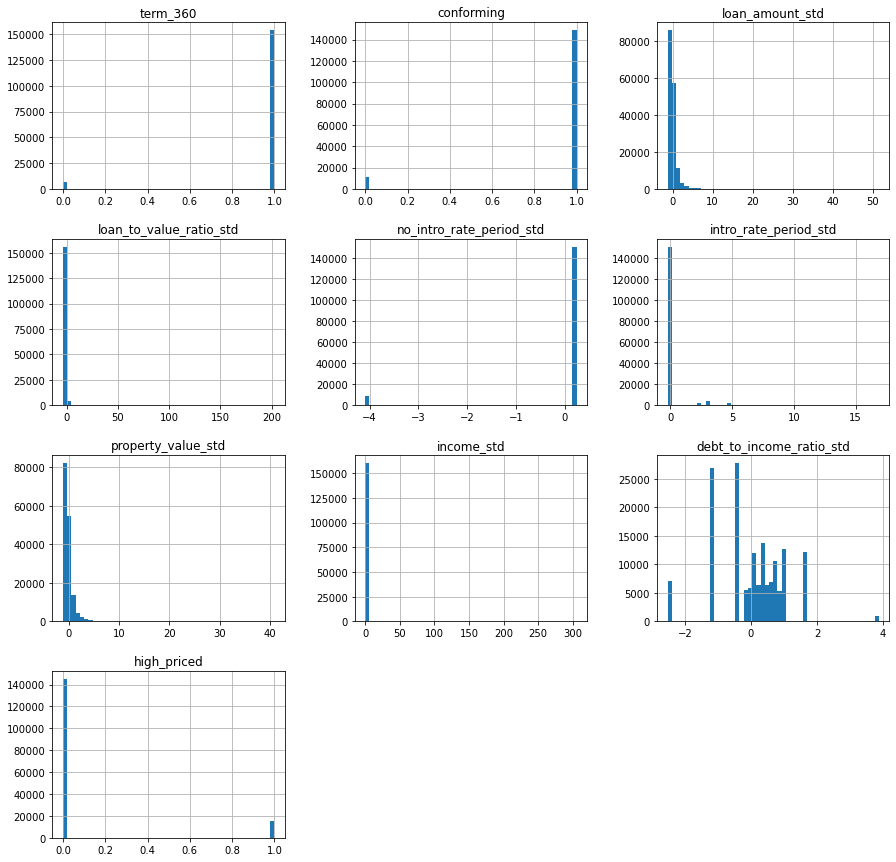

In [8]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))


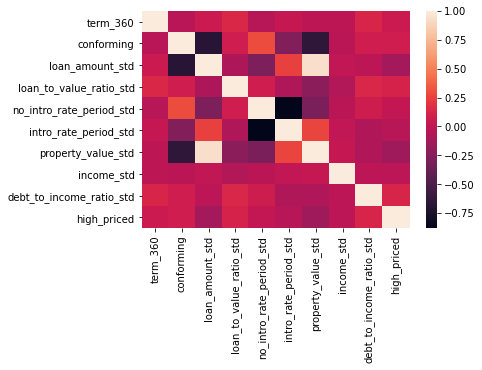

In [9]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)


Fit interpretable models

Split data into train and validation partitions


In [10]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23


Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


Elastic Net

Define wrapper function for grid search


In [11]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.3, 0.5, 0.6, 0.75, 0.8, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model


Fit elastic net with grid search


In [12]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))


/Users/harshitaggarwal/opt/anaconda3/lib/python3.8/site-packages/h2o/grid/grid_search.py:427: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


Elastic net GLM training completed in 25.10 s.


In [13]:
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_a4c462ab4547710d92e3ce2696a0406c.hex_model_python_1654129841008_1_model_8


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.99, lambda = 0.007062 )","nlambda = 100, lambda.max = 0.04136, lambda.min = 0.007062, lambda...",9,4,34,Key_Frame__upload_a4c462ab4547710d92e3ce2696a0406c.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.08251332157851761
RMSE: 0.2872513212824575
LogLoss: 0.2899862237861771
Null degrees of freedom: 112252
Residual degrees of freedom: 112248
Null deviance: 71663.33577025973
Residual deviance: 65106.6569113279
AIC: 65116.6569113279
AUC: 0.75477886750561
AUCPR: 0.22457478896616853
Gini: 0.5095577350112199

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12746672433655978: 


,,0,1,Error,Rate
0,0,77763.0,23563.0,0.2325,(23563.0/101326.0)
1,1,4487.0,6440.0,0.4106,(4487.0/10927.0)
2,Total,82250.0,30003.0,0.2499,(28050.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.127467,0.314684,162.0
1,max f2,0.104111,0.466275,206.0
2,max f0point5,0.155256,0.266588,112.0
3,max accuracy,0.394589,0.902684,11.0
4,max precision,0.394589,0.560000,11.0
5,max recall,0.000137,1.000000,399.0
6,max specificity,0.998902,0.999951,0.0
7,max absolute_mcc,0.121369,0.242135,173.0
8,max min_per_class_accuracy,0.115395,0.689851,184.0
9,max mean_per_class_accuracy,0.104111,0.696802,206.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.49 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010156,2.222064e-01,3.181023,3.181023,0.309649,0.266256,0.309649,0.266256,0.032305,0.032305,218.102343,218.102343,0.024538
1,2,0.020837,2.044061e-01,3.170148,3.175449,0.308590,0.211360,0.309106,0.238116,0.033861,0.066166,217.014812,217.544861,0.050218
2,3,0.030298,1.935179e-01,3.047074,3.135362,0.296610,0.198307,0.305204,0.225685,0.028828,0.094994,204.707434,213.536232,0.071673
3,4,0.041754,1.863794e-01,3.067519,3.116748,0.298600,0.189620,0.303392,0.215790,0.035142,0.130136,206.751906,211.674776,0.097914
4,5,0.050413,1.810878e-01,2.663369,3.038875,0.259259,0.183169,0.295812,0.210187,0.023062,0.153198,166.336869,203.887456,0.113870
5,6,0.100060,1.617423e-01,2.376079,2.710014,0.231294,0.170427,0.263800,0.190459,0.117965,0.271163,137.607906,171.001422,0.189555
6,7,0.150081,1.490695e-01,2.168032,2.529375,0.211042,0.155008,0.246216,0.178643,0.108447,0.379610,116.803158,152.937479,0.254282
7,8,0.200280,1.387555e-01,1.894169,2.370164,0.184383,0.143775,0.230718,0.169904,0.095086,0.474696,89.416863,137.016357,0.304009
8,9,0.300028,1.220170e-01,1.627605,2.123291,0.158435,0.129999,0.206687,0.156637,0.162350,0.637046,62.760476,112.329071,0.373362
9,10,0.399998,1.070768e-01,1.158939,1.882273,0.112814,0.114327,0.183225,0.146063,0.115860,0.752906,15.893867,88.227250,0.390965




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.08102911217723623
RMSE: 0.2846561297025522
LogLoss: 0.2858621601933513
Null degrees of freedom: 48084
Residual degrees of freedom: 48080
Null deviance: 30240.36713093873
Residual deviance: 27491.3639457946
AIC: 27501.3639457946
AUC: 0.7538148102147294
AUCPR: 0.2174957161569428
Gini: 0.5076296204294588

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13971324799629137: 


,,0,1,Error,Rate
0,0,36181.0,7326.0,0.1684,(7326.0/43507.0)
1,1,2403.0,2175.0,0.5249,(2403.0/4578.0)
2,Total,38584.0,9501.0,0.2023,(9729.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.139713,0.308971,141.0
1,max f2,0.101551,0.459445,212.0
2,max f0point5,0.163312,0.266580,101.0
3,max accuracy,0.997543,0.904752,0.0
4,max precision,0.400837,0.300000,7.0
5,max recall,0.000124,1.000000,399.0
6,max specificity,0.997543,0.999954,0.0
7,max absolute_mcc,0.120707,0.237725,175.0
8,max min_per_class_accuracy,0.114982,0.688004,186.0
9,max mean_per_class_accuracy,0.101551,0.694660,212.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010045,2.222380e-01,3.044491,3.044491,0.289855,0.267096,0.289855,0.267096,0.030581,0.030581,204.449130,204.449130,0.022697
1,2,0.020589,2.044061e-01,3.066109,3.055562,0.291913,0.211831,0.290909,0.238794,0.032329,0.062910,206.610899,205.556217,0.046774
2,3,0.030009,1.938378e-01,2.805569,2.977082,0.267108,0.198511,0.283437,0.226148,0.026431,0.089340,180.556930,197.708208,0.065574
3,4,0.040033,1.868320e-01,3.116182,3.011911,0.296680,0.190275,0.286753,0.217166,0.031236,0.120577,211.618212,201.191129,0.089019
4,5,0.050099,1.810878e-01,3.233514,3.056434,0.307851,0.183875,0.290992,0.210477,0.032547,0.153124,223.351395,205.643420,0.113866
5,6,0.100010,1.618235e-01,2.455192,2.756376,0.233750,0.170589,0.262425,0.190570,0.122543,0.275666,145.519195,175.637568,0.194139
6,7,0.150317,1.488313e-01,2.032094,2.513980,0.193468,0.155144,0.239347,0.178714,0.102228,0.377894,103.209411,151.397984,0.251524
7,8,0.200624,1.389927e-01,2.010384,2.387702,0.191401,0.143764,0.227325,0.169950,0.101136,0.479030,101.038370,138.770234,0.307701
8,9,0.300198,1.220508e-01,1.559730,2.113069,0.148496,0.130196,0.201178,0.156764,0.155308,0.634338,55.972952,111.306889,0.369300
9,10,0.400021,1.068868e-01,1.177267,1.879544,0.112083,0.114437,0.178945,0.146202,0.117519,0.751857,17.726673,87.954405,0.388858




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-01 20:31:26,0.000 sec,1,.41E-1,1,0.638409,0.628894,0.99,NaN,...,,,,,,,,,,
1,,2022-06-01 20:31:26,0.040 sec,3,.38E-1,3,0.633777,0.624362,0.99,NaN,...,,,,,,,,,,
2,,2022-06-01 20:31:26,0.073 sec,5,.34E-1,3,0.627905,0.618716,0.99,NaN,...,,,,,,,,,,
3,,2022-06-01 20:31:26,0.104 sec,7,.31E-1,3,0.622516,0.613542,0.99,NaN,...,,,,,,,,,,
4,,2022-06-01 20:31:26,0.148 sec,9,.29E-1,3,0.617581,0.608812,0.99,NaN,...,,,,,,,,,,
5,,2022-06-01 20:31:26,0.182 sec,11,.26E-1,3,0.613074,0.604501,0.99,NaN,...,,,,,,,,,,
6,,2022-06-01 20:31:27,0.229 sec,13,.24E-1,4,0.608870,0.600481,0.99,NaN,...,,,,,,,,,,
7,,2022-06-01 20:31:27,0.276 sec,15,.22E-1,4,0.604970,0.596741,0.99,NaN,...,,,,,,,,,,
8,,2022-06-01 20:31:27,0.316 sec,17,.2E-1,4,0.601479,0.593391,0.99,NaN,...,,,,,,,,,,
9,,2022-06-01 20:31:27,0.353 sec,19,.18E-1,4,0.598284,0.590297,0.99,NaN,...,,,,,,,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,property_value_std,0.922198,1.000000,0.625650
1,debt_to_income_ratio_std,0.331101,0.359035,0.224630
2,loan_to_value_ratio_std,0.207438,0.224939,0.140733
3,term_360,0.013247,0.014364,0.008987
4,conforming,0.000000,0.000000,0.000000
5,loan_amount_std,0.000000,0.000000,0.000000
6,no_intro_rate_period_std,0.000000,0.000000,0.000000
7,intro_rate_period_std,0.000000,0.000000,0.000000
8,income_std,0.000000,0.000000,0.000000


Basic AUC assessment


In [14]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))


Validation AUC: 0.7538.


Score validation data with model


In [15]:
best_glm_phat = best_glm.predict(hvalid).as_data_frame() 
best_glm_phat.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_phat.columns = ['phat']
best_glm_phat = pd.concat([valid.reset_index(drop=True), best_glm_phat], axis=1)
best_glm_phat.head()


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.158336
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.159289
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.070368
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.124670
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.045170


Utility function for selecting percentiles


In [16]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict


Select percentiles from predictions

In [17]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_phat, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))


0: 152878
10: 154185
20: 74908
30: 37440
40: 138502
50: 78582
60: 139677
70: 156880
80: 26748
90: 95570
99: 46601


Collect global feature importance info


In [18]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_fi.drop('Intercept', inplace=True)
global_fi['GLM Importance'] = np.abs(global_fi['GLM Importance'])


Collect local feature importance info


In [19]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_names)}

# get (coefficient * value) at three percentiles of phat
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            valid[valid['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]


Monotonic XGBoost

Define utility function for random grid search


In [20]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate


Fit monotonic XGBoost with random grid search


In [22]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}



# define monotonicity constraints
#mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])
mono_constraints = (1, 1, 1, 1, -1, 0, -1, 0)

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=10, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))


Grid search run 1/10:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/10: 0.8065.
---------- ----------
Grid search run 2/10:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, 1, -1, 0, -1, 0)}
Grid search new best score discovered at iteration 2/10: 0.8079.
---------- ----------
Grid search run 3/10:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objecti

Basic AUC assessment


In [23]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)


Validation AUC: 0.8092.


Score validation data with model


In [24]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat']) 
best_mxgb_phat = pd.concat([valid.reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.170881
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.272879
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.026078
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.023510
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.006208


Select percentiles from predictions


In [25]:
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_phat, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

0: 48081
10: 76614
20: 99189
30: 60401
40: 38717
50: 39606
60: 8508
70: 32893
80: 21188
90: 103682
99: 151812


Calculate Shapley values

In [26]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_ntree_limit))

Collect global feature importance info

In [27]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_names + ['intercept'])
global_fi['MXGB Importance'] = np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean()

Collect local feature importance info

In [33]:
# create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=x_names)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

Explainable Boosting Machine

Define utility function for random grid search



In [34]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate


Fit EBM with random grid search


In [35]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))


Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8214.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

Basic AUC assessment


In [36]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])


Validation AUC: 0.8249.


Score validation data with model

In [37]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.170768
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.324085
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.023633
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.016289
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004135


Select percentiles from predictions

In [38]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 112323
10: 73566
20: 18627
30: 12113
40: 15450
50: 49438
60: 43071
70: 13537
80: 159351
90: 40856
99: 33940


Calculate EBM contributions

In [39]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 24), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

EBM contributions collected in 136.08 s.


Collect global feature importance info

In [40]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

Collect local feature importance info

In [41]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df


Analyze feature importance

Compare global feature importance across models

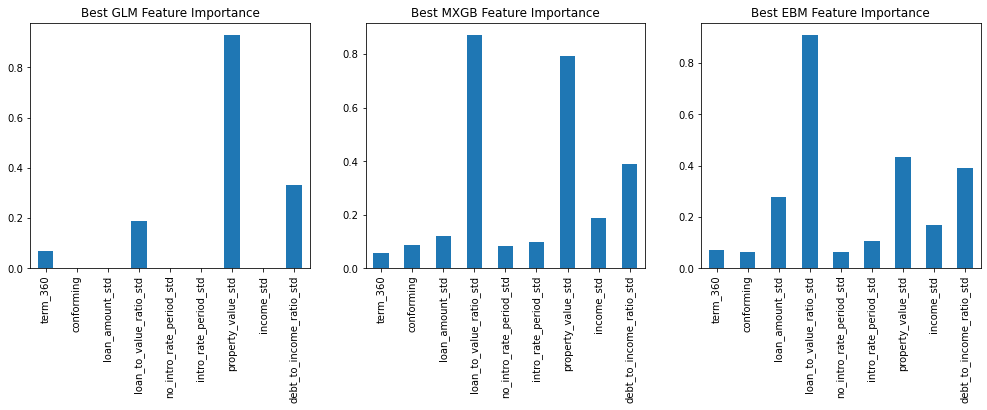

In [42]:
# init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_fi['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_fi['MXGB Importance'].plot(kind='bar', ax=ax1, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax2, title='Best EBM Feature Importance')


Compare local feature importance across models

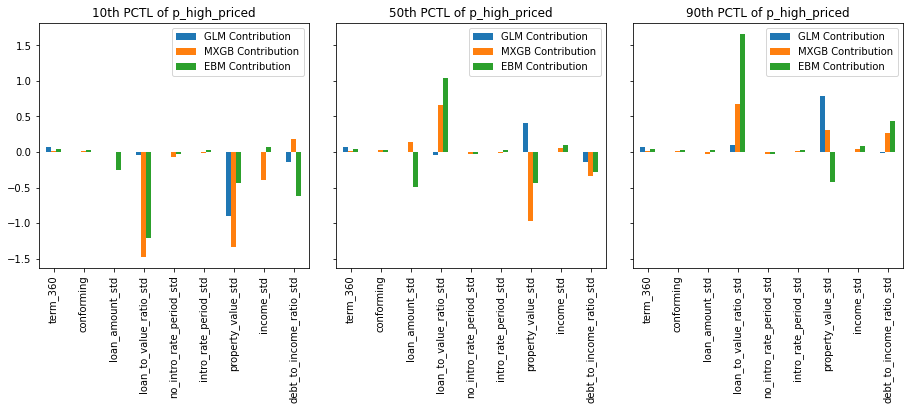

In [43]:
## init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')


Utility function for partial dependence

In [44]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()


Calculate partial dependence for all X and models

In [45]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']
    
    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, valid[x_names], best_mxgb, 'xgb', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 282.44 s.


Plot partial dependence for all features and models

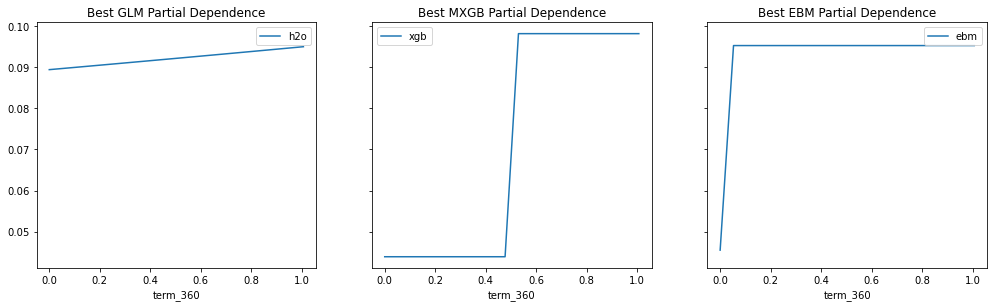

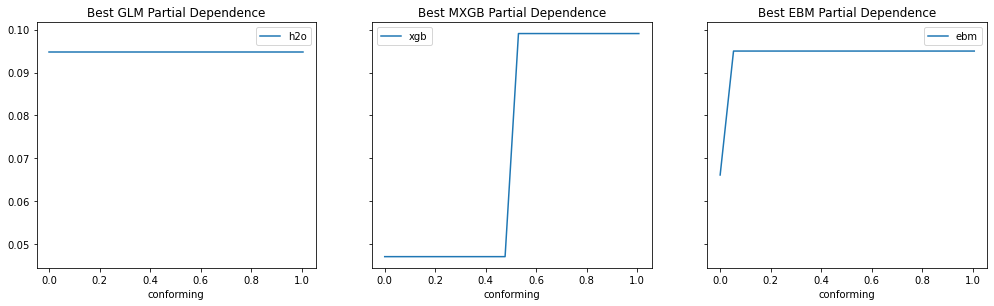

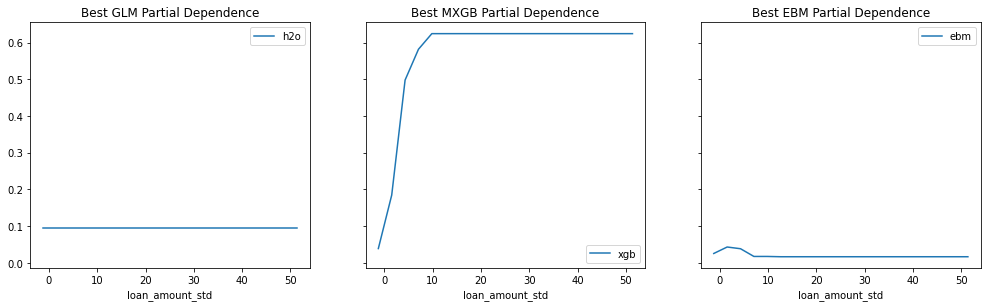

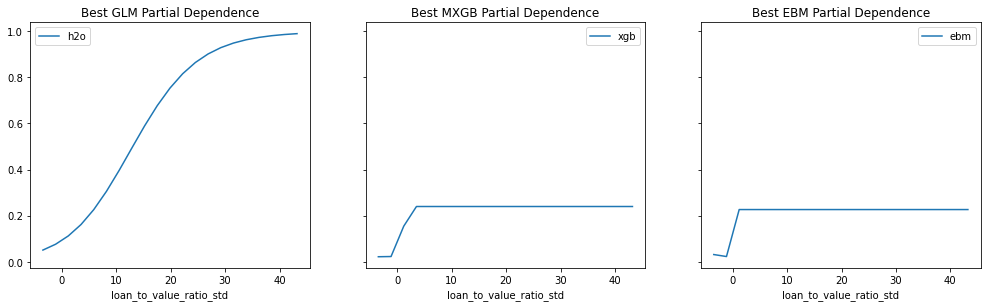

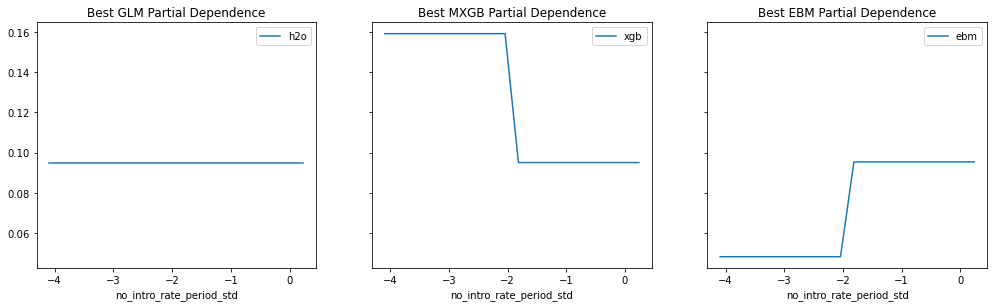

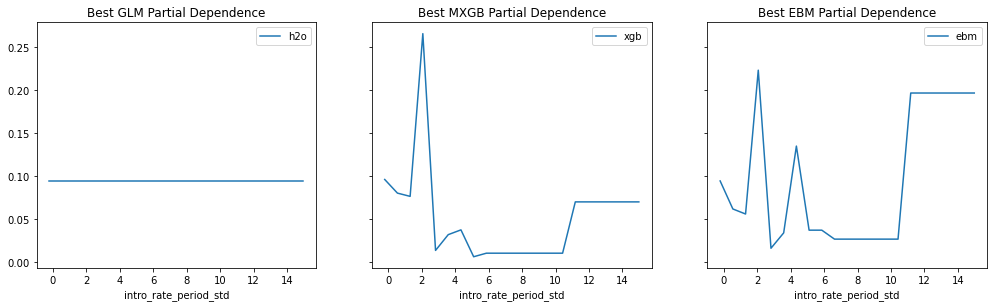

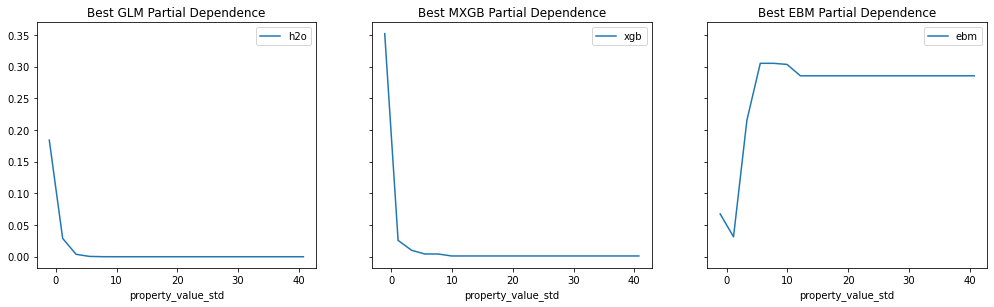

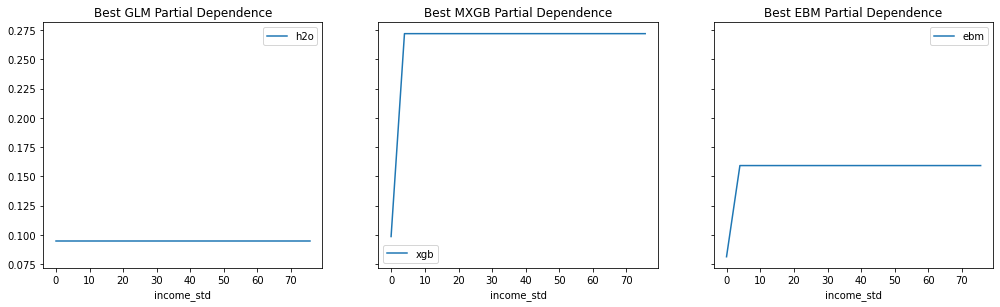

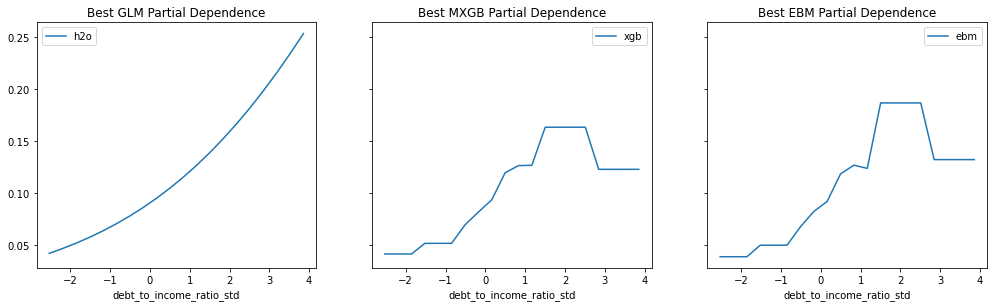

In [46]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best MXGB Partial Dependence') 
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)

End timer


In [44]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))


All tasks completed in 5988.76 s.


Shutdown h2o


In [45]:
h2o.cluster().shutdown(prompt=False)


H2O session _sid_9fca closed.
